# Visualise Trained Pytorch model and results

## Import libraries and plot training

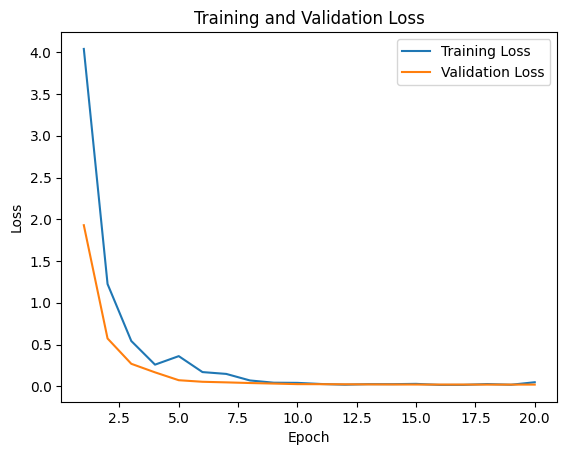

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
from anytree import Node
from anytree.importer import JsonImporter
import torch.nn as nn
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
from models.hierarchical_cnn import HierarchicalCNN
from utils.custom_dataset import CustomDataset

# Read the training log file
training_log = pd.read_csv('training_log.csv')

# Plot the training and validation loss
plt.plot(training_log['Epoch'], training_log['Training Loss'], label='Training Loss')
plt.plot(training_log['Epoch'], training_log['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Extract test data

In [2]:
# %%
df = pd.read_parquet('/mnt/RAID/projects/FjordVision/data/segmented-objects-dataset.parquet')

# Assuming df is your DataFrame with all data
train_val_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Load The Model and Ontology

In [3]:
importer = JsonImporter()
root = importer.read(open('data/ontology.json', 'r'))

classes_file = '/mnt/RAID/datasets/label-studio/fjord/classes.txt'

species_names = []
with open(classes_file, 'r') as file:
    species_names = [line.strip() for line in file]

genus_names = [node.name for node in root.descendants if node.rank == 'genus']
class_names = [node.name for node in root.descendants if node.rank == 'class']
binary_names = [node.name for node in root.descendants if node.rank == 'binary']

def get_hierarchical_labels(species_index, root):
    if species_index == -1:
        return -1, -1, -1  # Handle cases where species_index is invalid

    species_name = species_names[species_index]
    node = next((n for n in root.descendants if n.name == species_name), None)

    if node is None:
        return -1, -1, -1  # Species not found in the tree

    # Traverse up the tree to find genus, class, and binary ranks
    genus_index, class_index, binary_index = -1, -1, -1
    current_node = node

    while current_node.parent is not None:
        current_node = current_node.parent
        if current_node.rank == 'genus':
            genus_index = genus_names.index(current_node.name)
        elif current_node.rank == 'class':
            class_index = class_names.index(current_node.name)
        elif current_node.rank == 'binary':
            binary_index = binary_names.index(current_node.name)

    return genus_index, class_index, binary_index

# Create a defaultdict to store the counts for each rank
rank_counts = defaultdict(int)

# Iterate over the nodes of the tree
for node in root.descendants:
    rank = node.rank
    rank_counts[rank] += 1

# Example instantiation of the model
num_classes_hierarchy = list(rank_counts.values())  # Example: [num_species, num_genus, num_class, num_binary]
num_additional_features = 3  # Assuming 3 additional features: conf, iou, pred_species

model = HierarchicalCNN(num_classes_hierarchy, num_additional_features)
model.load_state_dict(torch.load('models/weights/leveldepth_best_model.pth'))

<All keys matched successfully>

# Load Dataloader

In [4]:
test_dataset = CustomDataset(test_df, species_names, genus_names, class_names, binary_names, root)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Extract Predictions on test data

In [5]:
(test_df['predicted_species'] == test_df['species']).sum() / len(test_df)

0.9843884582256676

In [6]:
from sklearn.metrics import f1_score
import numpy as np

# Initialize lists to store true labels and predictions for each level
true_labels = {level: [] for level in ['binary', 'class', 'genus', 'species']}
predictions = {level: [] for level in ['binary', 'class', 'genus', 'species']}

model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.eval()
with torch.no_grad():
    for images, conf, iou, pred_species, species_index, genus_index, class_index, binary_index in test_loader:
        images, conf, iou, pred_species = images.to(device), conf.to(device), iou.to(device), pred_species.to(device)
        
        outputs = model(images, conf, iou, pred_species)
        
        # Convert model outputs to predictions
        for i, output in enumerate(outputs):  # For each hierarchical level
            _, predicted = torch.max(output, 1)
            level = ['binary', 'class', 'genus', 'species'][i]
            predictions[level].extend(predicted.cpu().numpy())
        
        # Store true labels
        true_labels['binary'].extend(binary_index.cpu().numpy())
        true_labels['class'].extend(class_index.cpu().numpy())
        true_labels['genus'].extend(genus_index.cpu().numpy())
        true_labels['species'].extend(species_index.cpu().numpy())

In [7]:
f1_scores = {}
for level in ['binary', 'class', 'genus', 'species']:
    f1_scores[level] = f1_score(true_labels[level], predictions[level], average='macro')
    print(f"F1 Score for {level}: {f1_scores[level]:.4f}")

F1 Score for binary: 0.3250
F1 Score for class: 0.0292
F1 Score for genus: 0.0099
F1 Score for species: 0.0287


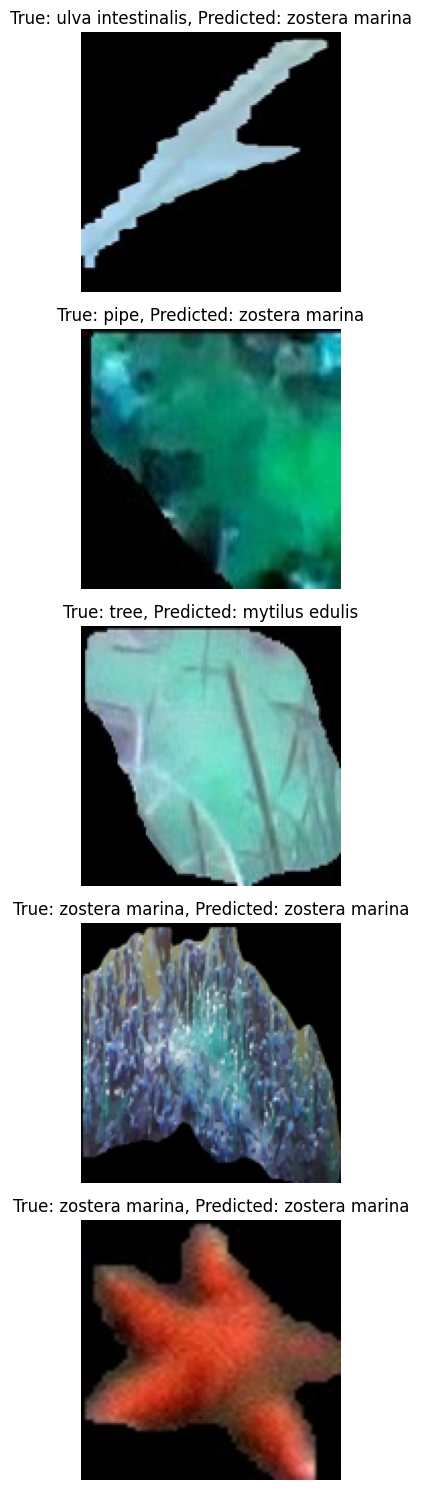

In [8]:
import matplotlib.pyplot as plt

def visualize_predictions(images, true_labels, predictions, idx_to_class, num_images=5):
    images = images.cpu().numpy()
    fig, axs = plt.subplots(num_images, 1, figsize=(10, num_images * 3))
    
    for i, ax in enumerate(axs):
        img = np.transpose(images[i], (1, 2, 0))  # Convert from CHW to HWC format
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"True: {idx_to_class[true_labels[i]]}, Predicted: {idx_to_class[predictions[i]]}")
    
    plt.tight_layout()
    plt.show()

# Example usage (adjust as needed):
# This assumes you have a way to map from index to class name (idx_to_class)
# You might need to adjust based on how your classes are structured
visualize_predictions(images[:5], true_labels['species'][:5], predictions['species'][:5], idx_to_class=species_names)